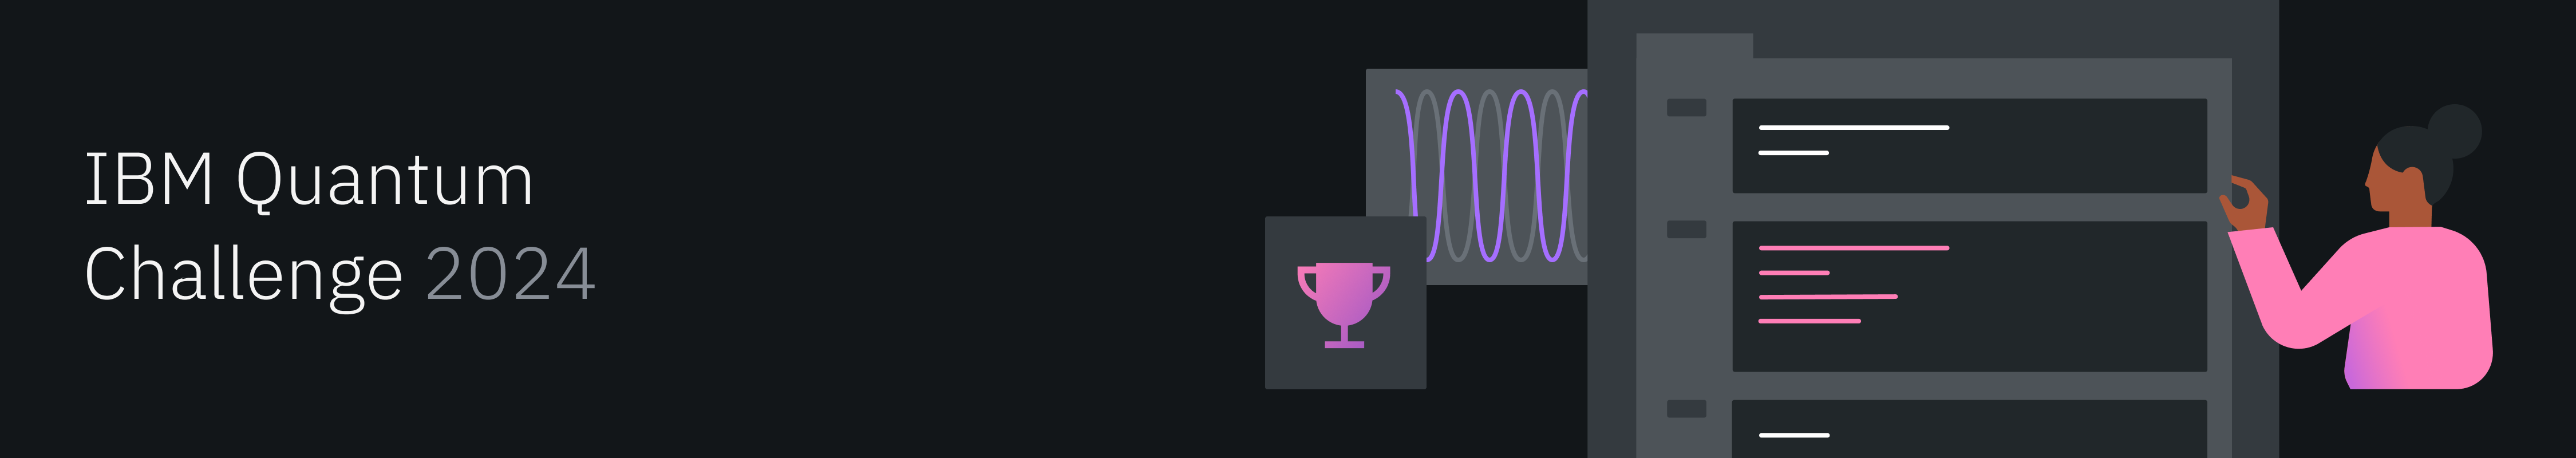
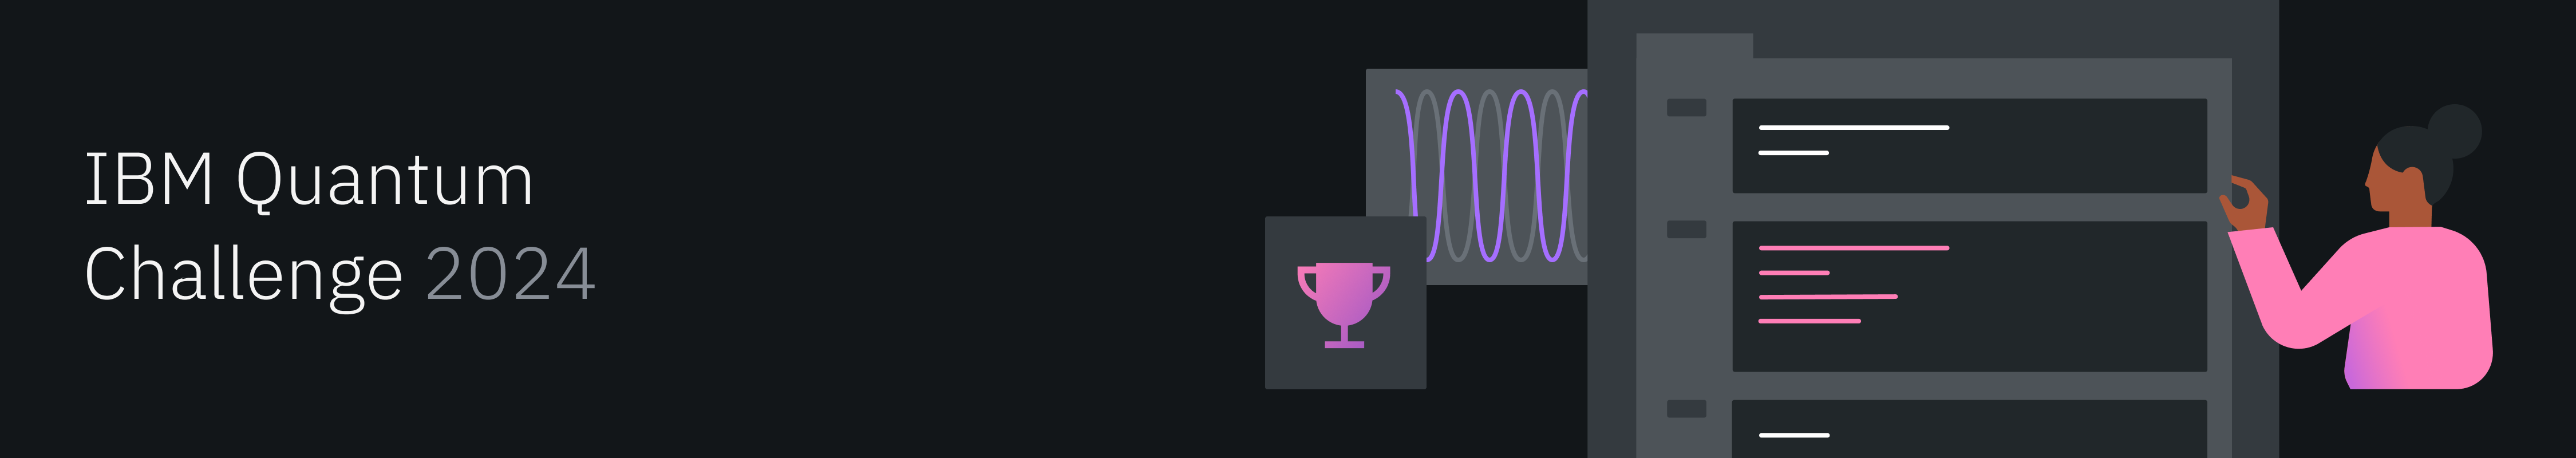

# Lab 5: Upcoming Features Challenge

# Table of Contents

* [Part 1: Circuit Knitting Toolbox](#Part-1:-Circuit-Knitting-Toolbox)
    * [Exercise 1](#exercise1)
    * [Exercise 2](#exercise2)
* [Part 2: Custom Fake Backends](#Part-2:-Custom-Fake-Backends)
    * [Exercise 3](#exercise3)
    * [Exercise 4](#exercise4)
    * [Exercise 5](#exercise5)    
* [Part 3: Qiskit Code Assistant](#Part-3:-Qiskit-Code-Assistant)

# Imports

To install Graphviz, please refer [Graphviz documents](https://graphviz.gitlab.io/download/).

In [1]:
#install esssential libraries
#!pip install circuit-knitting-toolbox graphviz

In [2]:
# Import all in one cell

# Import common packages first
import numpy as np

# Import qiskit classes
from qiskit import QuantumCircuit, ClassicalRegister, QuantumCircuit, transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.result import marginal_counts
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_gate_map
from qiskit.quantum_info import SparsePauliOp

# Import qiskit ecosystems
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeTorino
from qiskit_aer import AerSimulator
from circuit_knitting.cutting import cut_gates
from circuit_knitting.cutting import generate_cutting_experiments

# Imports for the fakebackend
import math
import numpy as np
import rustworkx as rx
from qiskit.providers import BackendV2, Options
from qiskit.transpiler import Target, InstructionProperties
from qiskit.circuit.library import XGate, SXGate, RZGate, CZGate, ECRGate
from qiskit.circuit import Measure, Delay, Parameter, IfElseOp, Reset
import os
from qiskit.visualization import plot_gate_map, plot_circuit_layout

In [3]:
# For Testing purposes. Will remove for the final version

# This is required during testing phase. If you see the following error message:
# Failed: {'errors': [{'message': 'The challenge is not active', 'extensions': {'code': 'INVALID_QUERY'}}]}
# Restart the kernel and run this cell
%set_env QC_GRADE_ONLY=true

# If you see the following error message:
# Failed: Unable to access service (Forbidden)
# Uncomment the line below and copy and past your IBM Quantum token. See lab 0 for more detailed instructions
# %set_env QXToken=#your_token_here

env: QC_GRADE_ONLY=true


In [4]:
# Import for grader
from qc_grader.challenges.iqc_2024 import grade_lab5_ex1, grade_lab5_ex2, grade_lab5_ex3, grade_lab5_ex4, grade_lab5_ex5

# Part 1: Circuit Knitting Toolbox

Circuit cutting is a technique to increase the size of circuits we can run on quantum hardware at the cost of an additional sampling overhead. A larger quantum circuit can be decomposed by cutting its gates and/or wires, resulting in smaller circuits which can be executed within the constraints of available quantum hardware. The results of these smaller circuits are combined to reconstruct the outcome of the original problem. Circuit cutting can also be used to engineer gates between distant qubits which would otherwise require a large swap overhead.

### How do we overcome the limited connectivity?

Superconducting processors have limited connectivity. How do we overcome this? One of the solution is Circuit knitting with Local Operations and Classical Communication (LOCC).

### Theory

A quantum channel $\varepsilon$ can be decomposed into a linear combination of several channels $\varepsilon_i$ with coefficients $a_i$. Therefore, a virtual gate also is implemented by a sum over several circuits:

$$\varepsilon(\cdot) = \sum_i a_i \varepsilon(\cdot)$$
The $a_i$ do not form a valid probability decomposition since some $a_i<0$ cannot sample. We transform to a valid probability distribution via:

$$\gamma = \sum   |a_i| $$

So $\sum\frac{|a_i|}{\gamma}=1$. Therefore, $\frac{|a_i|}{\gamma}$ form a valid probability distribution:

$$\varepsilon(\rho) =\gamma \sum_i \frac{|a_i|}{\gamma} sign(a_i) \varepsilon_i(\cdot)$$
This allows us to cut gates.

### Single CNOT example

A CNOT gate can be deterministically implemented by consuming a Bell pair in a  teleportation circuit.

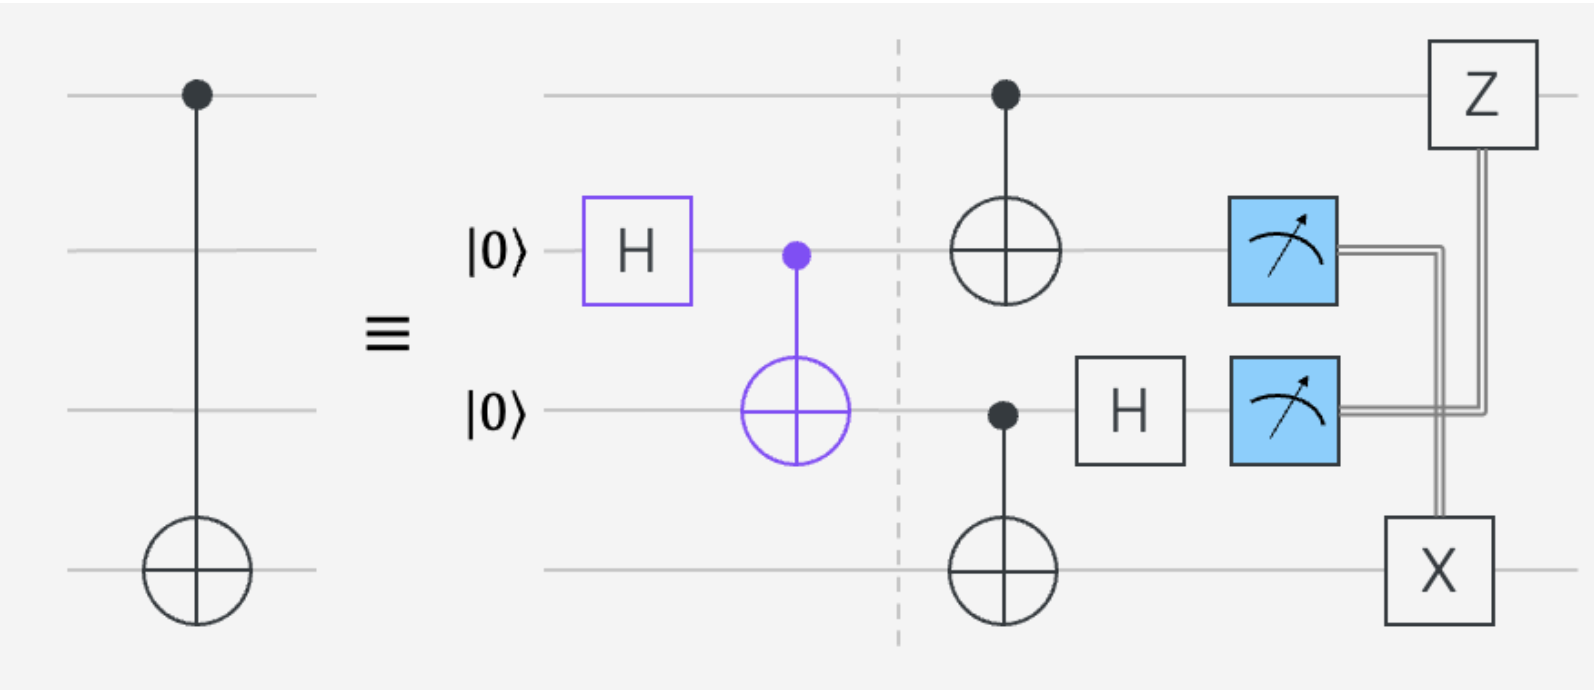
We will check it by applying H gate and CNOT gate between qubit_0 and qubit_3 so that we create the entanglement state of $|00\rangle$ and $|11\rangle$.

<a id="exercise1"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 1:</b> 

Create the circuit on the right side of the figure above using a "dynamic circuits". H gate is already added to qubit 0 to create the entanglement.

</div>

In [ ]:
circuit = QuantumCircuit(4, 4)

circuit.h(0)    # for creating the bell state between q0 and q3

## your code goes here ##

circuit.measure(0,0)
circuit.measure(3,3)

circuit.draw("mpl")

In [ ]:
# Submit your answer using following code

grade_lab5_ex1(circuit)    # Expected result type: QuantumCircuit

We will run this circuit using AerSimulator. `marginal_counts` is marginalize counts from an experiment over some indices of interest.

In [ ]:
# Run the circuit on a simulator to get the results
backend = AerSimulator()

pm = generate_preset_pass_manager(backend=backend, optimization_level=1, seed_transpiler=0)
isa_qc = pm.run(circuit)

sampler = Sampler(backend)
job = sampler.run([isa_qc])

counts = job.result()[0].data.c.get_counts()
print(counts)

# Plot the marginal counts in a histogram
qubit0_3 = marginal_counts(counts, [0, 3])

plot_histogram(qubit0_3)

We confirmed that A CNOT gate can be deterministically implemented by consuming a Bell pair in a teleportation circuit!

However, it is not always possible to create the Bell pair with a CNOT gate. For example, if the qubits are far apart, we can perform circuit knitting by cutting the Bell pair and implementing it with a **Quasi-probability decomposition (QPD)**.

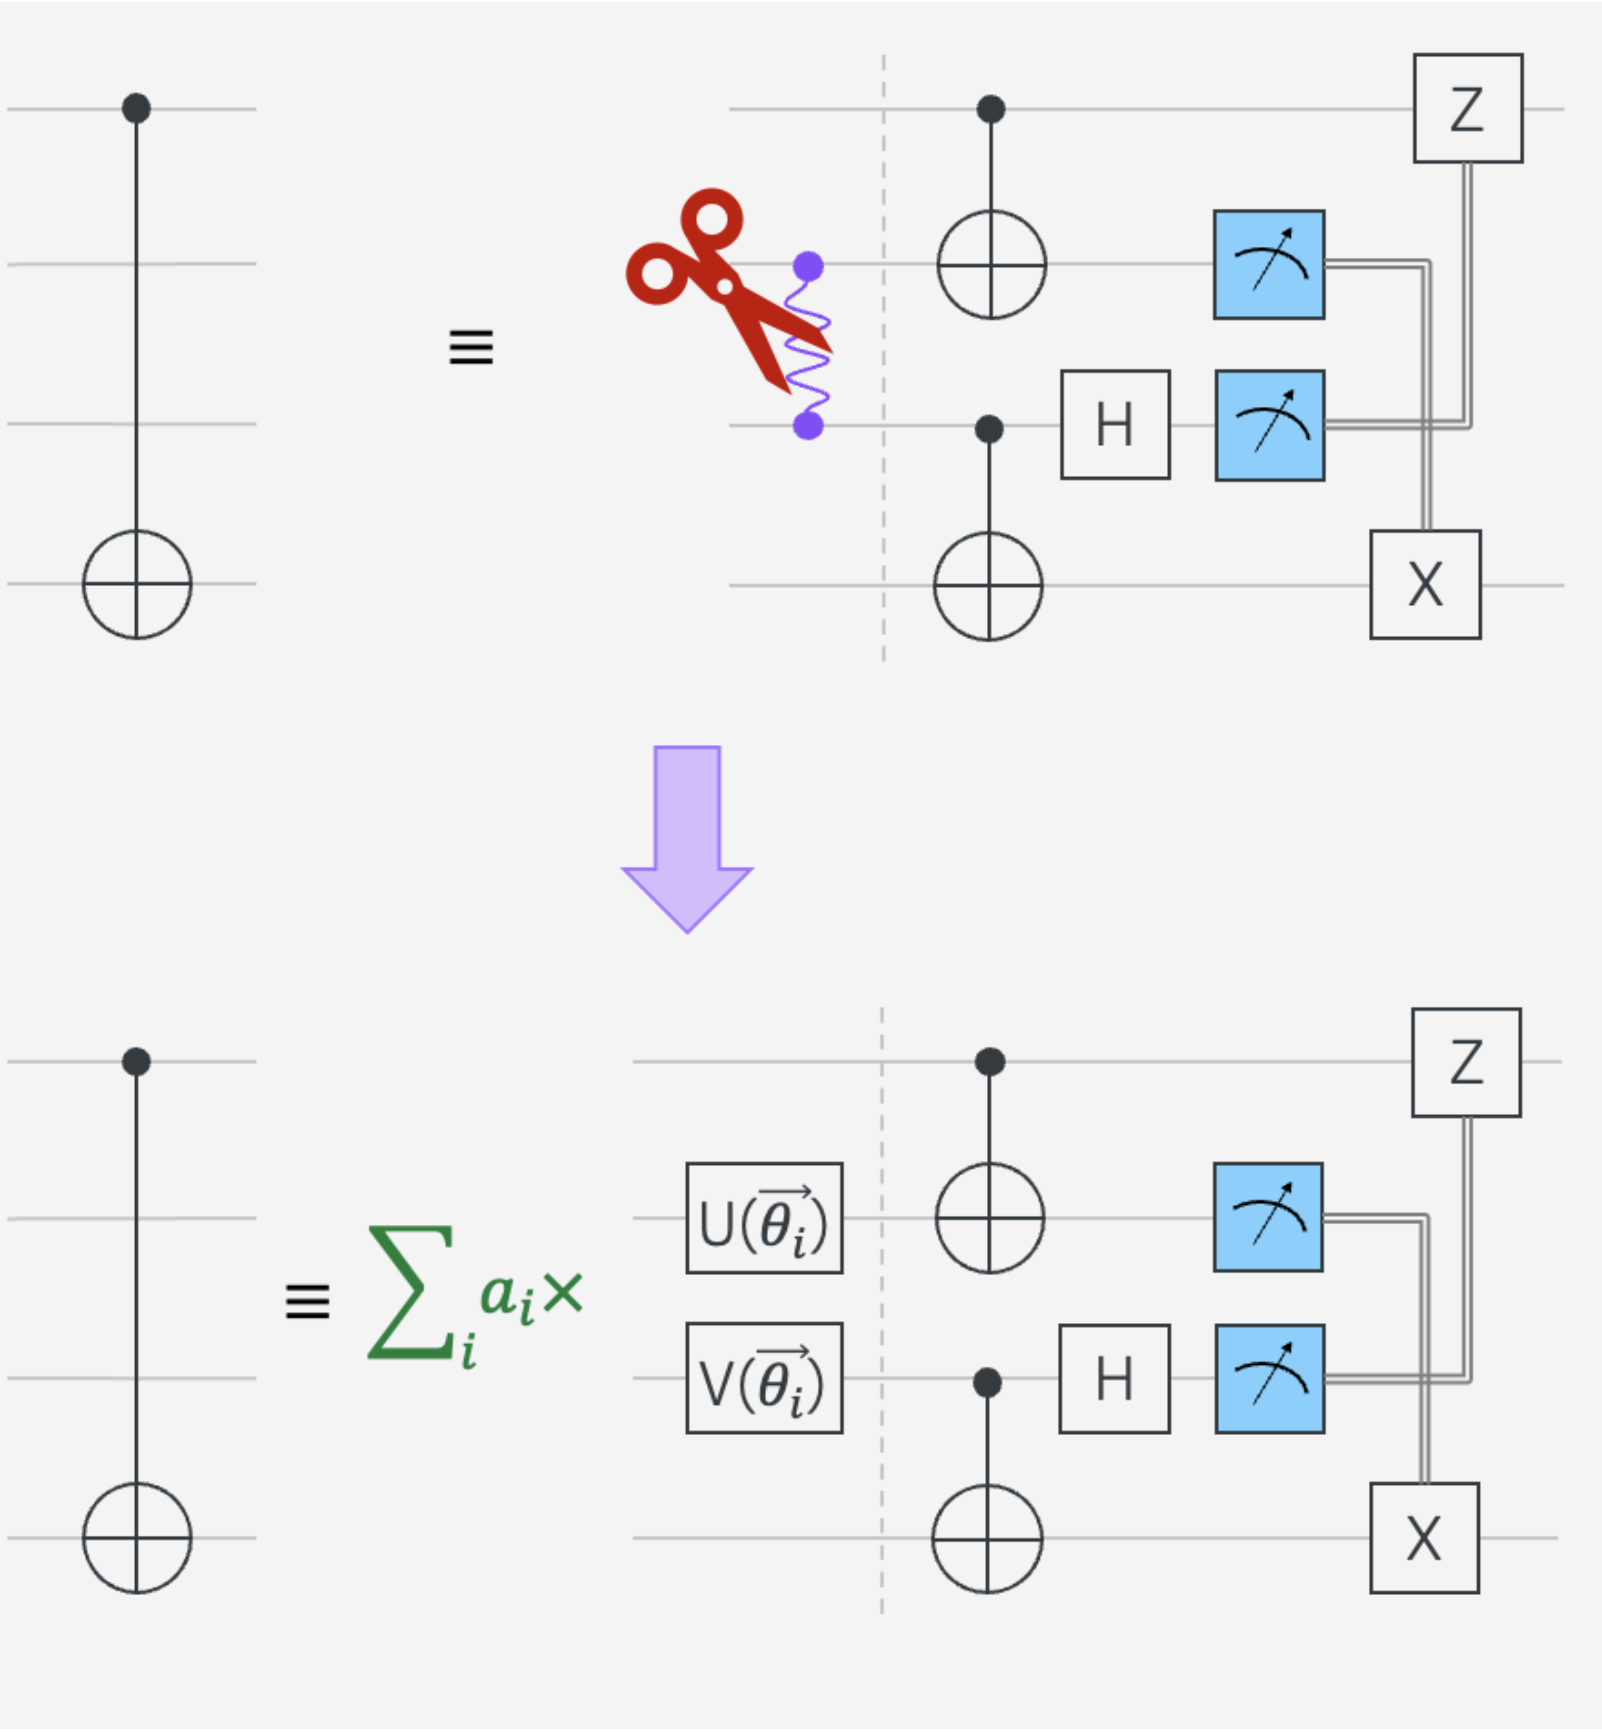


Now the top two and bottom two qubits are only connected via classical communication. The price we pay is to have to run several quantum circuits instead of one.  

### Example of a gate cutting in Bell circuit 
Now, let's think about only a Bell pair which are far apart.  We will investigate how we cut CNOT gate using Qiskit Circuit Knitting Toolbox in case where the two qubits are far apart.

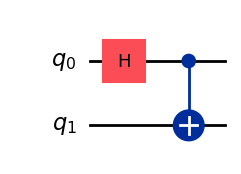

In [5]:
# create a bell pair
bell_state = QuantumCircuit(2)
bell_state.h(0)
bell_state.cx(0,1)
bell_state.draw("mpl")

We will use `FakeTorino` device, here. 

In [6]:
backend = FakeTorino()

In [7]:
### If you want to use the real device, you can try with below code.
# service = QiskitRuntimeService()
# backend = service.get_backend("ibm_kyoto")

Now, we choose a layout that requires many swaps to execute the gates between qubits 122 and 126 and another many swaps to return the qubits to their initial positions.

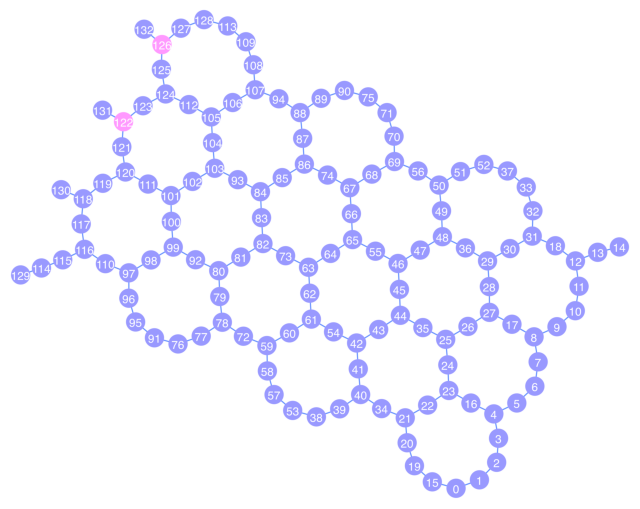

In [9]:
layout=[122, 126]
qubit_color = []
for i in range(133):
    if i in layout:
        qubit_color.append("#ff99ff")
    else:
        qubit_color.append("#9999ff")
plot_gate_map(backend, qubit_color=qubit_color, qubit_size=80, font_size=40, figsize=(8,8))

We will transpile the bell pair circuit to get the Instruction Set Architecture (ISA) circuit which the device can understand and execute.

Transpiled circuit depth:  31


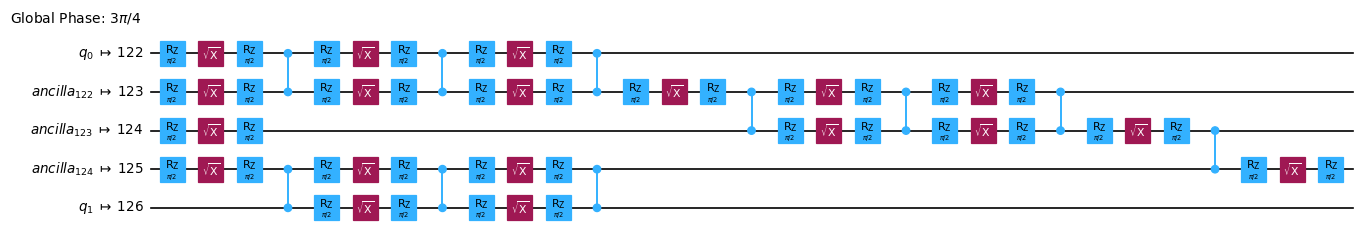

In [10]:
# transpile the circuit
pm = generate_preset_pass_manager(backend=backend, optimization_level=1, initial_layout = layout, seed_transpiler=0)
isa_qc = pm.run(bell_state)

# original circuit depth
isa_qc_depth = isa_qc.depth()
print(f"Transpiled circuit depth: ", isa_qc_depth)
isa_qc.draw("mpl", idle_wires=False, style="iqp", scale=0.6, fold=-1)

We see that many ancilla qubits are used and the depth of the transpiled circuit is 31! This is the case if we don't use Qiskit Circuit Knitting Toolbox.

Now, we will introduce Circuit Knitting.    
We will replace the distant gates (gates connecting non-local qubits, 122 and 126) with `TwoQubitQPDGate`s by specifying their indices. `cut_gates` will replace the gates in the specified indices with `TwoQubitQPDGate`s and also return a list of `QPDBasis` instances -- one for each gate decomposition. The ``QPDBasis`` object contains information about how to decompose the cut gates into single-qubit operations.

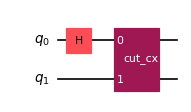

In [11]:
# Find the indices of the distant gates
cut_indices = [
    i
    for i, instruction in enumerate(bell_state.data)
    if {bell_state.find_bit(q)[0] for q in instruction.qubits} == {0, 1}
]

# Decompose distant CNOTs into TwoQubitQPDGate instances
qpd_circuit, bases = cut_gates(bell_state, cut_indices)

qpd_circuit.draw("mpl", style="iqp", scale=0.6)

In the next cell, `generate_cutting_experiments` accepts a circuit containing `TwoQubitQPDGate` instances and observables as a `PauliList`. 

To simulate the expectation value of the full-sized circuit, many subexperiments are generated from the decomposed gates' joint quasiprobability distribution and then executed on one or more backends. The number of samples taken from the distribution is controlled by `num_samples`, and one combined coefficient is given for each unique sample. For more information on how the coefficients are calculated, refer to the [explanatory material](https://github.com/Qiskit-Extensions/circuit-knitting-toolbox/blob/main/docs/circuit_cutting/explanation/index.rst).

In [12]:
observable = SparsePauliOp(["ZI"])

# Generate the subexperiments and sampling coefficients
subexperiments, coefficients = generate_cutting_experiments(
    circuits=qpd_circuit, observables=observable.paulis, num_samples=np.inf
)

Here is an example of an arbitrarily chosen subexperiment generated from the QPD circuit. Its depth has been reduced significantly from 31 to 7. Many of these probabilistic subexperiments must be generated and evaluated in order to reconstruct an expectation value of the deeper circuit. For this circuit, we need 6 subexperiments to reconstruct it.

Original circuit depth after transpile:  31
QPD subexperiment depth after transpile:  7
Number of sub-experiments: 6


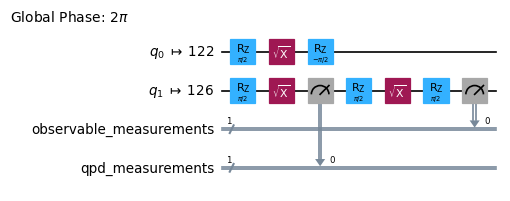

In [13]:
# Transpile the circuit
pm = generate_preset_pass_manager(backend=backend, optimization_level=1, initial_layout = layout, seed_transpiler=0)
isa_qpd_circuit = pm.run(subexperiments[5])

# depth using circuit cutting
isa_qpd_depth = isa_qpd_circuit.depth()

print(f"Original circuit depth after transpile: ", isa_qc_depth)
print(f"QPD subexperiment depth after transpile: ", isa_qpd_depth)
print(f"Number of sub-experiments:", len(subexperiments))
isa_qpd_circuit.draw("mpl", scale=0.6, style="iqp", idle_wires=False, fold=-1)

The above circuit is 5th circuit in 6 subexperiments. Let's see the depth of all subexperiments.

In [14]:
x = np.array([c.depth() for c in pm.run(subexperiments)])
print(x)

[4 3 3 3 7 7]


In order to know the expectation value of the original circuit, a number of subexperiments must be executed. I this case, the six circuit need to be run and reconstructed using subobservables, and sampling coefficients. Therefore, using the circuit cutting, the depth of each circuit is decreased significantly, but a lot of circuits need to be executed.
For more information, please refer the tutorial ["Gate Cutting to Reduce Circuit Depth"](https://qiskit-extensions.github.io/circuit-knitting-toolbox/circuit_cutting/tutorials/02_gate_cutting_to_reduce_circuit_depth.html).

<a id="exercise2"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 2:</b> 

Which gate connections should be cut to minimize the circuit depth of the Toffoli gate? Assume that each qubit of the Toffoli gate is located at [122, 124, 126] on `FakeTorino` device. Answer the gates connecting to cut ({0, 1}, etc.), the depth without using circuit cutting (the original circuit depth), and the average depth with using circuit cutting.    
Note: Use `optimization_level=1` and `seed_transpiler=0` as the arguement of `generate_preset_pass_manager()`
</div>

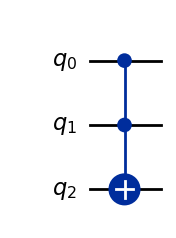

In [15]:
toffoli_layout = [122, 124, 126]

toffoli = QuantumCircuit(3)
toffoli.ccx(0, 1, 2)
toffoli.draw("mpl")

In [ ]:
# To know the original circuit depth

# transpile the circuit
## your code goes here ##

# original circuit depth
## your code goes here ##
isa_toffoli_depth = 

print(f"Transpiled circuit depth: ", isa_toffoli_depth)
#isa_qc.draw("mpl", scale=0.6, idle_wires=False, style="iqp", fold=-1)

In [ ]:
# To know the depth using circuit cutting

## your code goes here ##

# Find the indices of the distant gates
## your code goes here ##
gates_connecting_to_cut =

# Decompose distant CNOTs into TwoQubitQPDGate instances
## your code goes here ##


#qpd_circuit.draw("mpl", style="iqp", scale=0.6)

In [ ]:
# set the observables
observable = SparsePauliOp(["ZZZ"])

# Generate the subexperiments and sampling coefficients
# Add your code here

# Transpile the circuit
# Add your code here

# Depth using circuit cutting
# Add your code here
isa_qpd_toffoli_depth =

print(f"Transpiled circuit depth: ", isa_toffoli_depth)
print(f"QPD subexperiment depth after transpile: ", isa_qpd_toffoli_depth)
#print(f"Number of sub-experiments:", len(subexperiments))
#isa_qpd_circuit.draw("mpl", scale=0.6, style="iqp", idle_wires=False, fold=-1)

In [ ]:
# mean of the depth of all subexperiments
# Add your code here

isa_qpd_toffoli_depth_mean =

print(isa_qpd_toffoli_depth_mean)

In [ ]:
# Submit your answer using following code

grade_lab5_ex2(gates_connecting_to_cut, isa_toffoli_depth, isa_qpd_toffoli_depth_mean) 
# Expected result type: dict, str, str

**Open question** to those who finished the exercise and have extra power: What would be the depth if more than two connections are cut?

# Part 2: Custom Fake Backends

IBM has developed various topologies (connection between the qubits) for quantum processors, including transmon qubits and coupled qubit architectures, enabling the execution of more complex quantum operations. [Qiskit Pulse](https://docs.quantum.ibm.com/api/qiskit/pulse) allows users gain direct access to qubit control signals, enhancing flexibility in circuit design. IBM has made strides in increasing the size of quantum circuits that can be executed, with processors boasting up to 1121 qubits on Condor and 133 on Heron. Although not all qubits may be fully connected.

Now if we want to learn more about the potential of future hardware, Qiskit 1.0 offers a way that you can build **fake backends** that has futuristic topologies using the `BackendV2` module.

In this exercise, we are trying to make a fake backend that are closely reassemble future backend in the roadmap and we can start using it and develop software and when the backend is online we can run it straight away.


### Backend topologies
Before we start building a fake backend, we need to point out that backends have different topologies (graph) and we need to design out circuit according to that topology of the backend. Qiskit 1.0 offers several types of topologies, some of these topologies are:
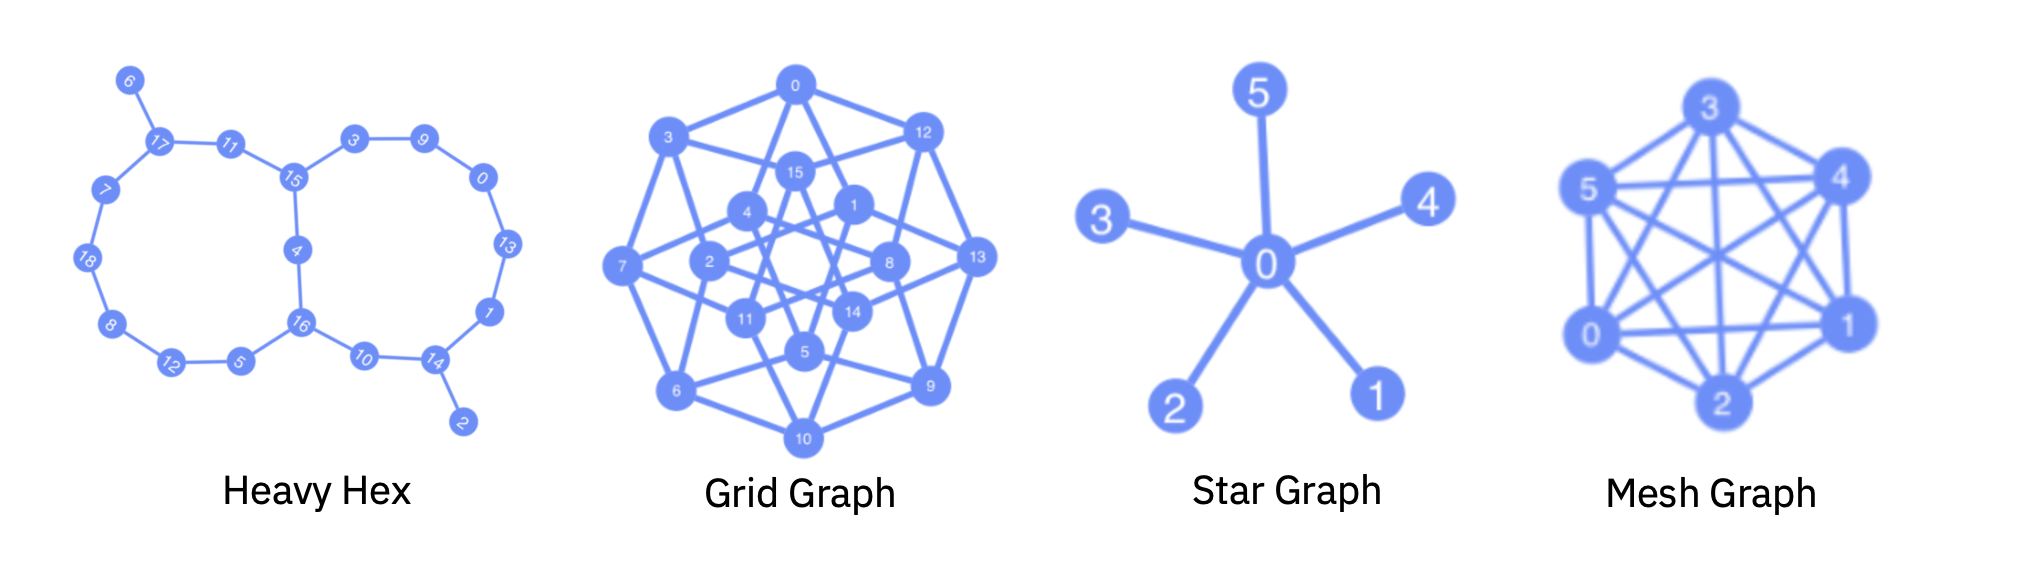
To learn more about the different possible topologies, check the [RustWorkX](https://www.rustworkx.org/stable/0.12/api.html#generators) API documentation. 

In this exercise, we will create two fake backends useing 1) **the heavy hex** with multiple chips and 2) **the grid graph**.

### Create the fake backend
To build a fake backend, we would need to define the following components:

1. **Topology:** Define a topology (graph) using the rustworkx library

2. **Basis gates:** Select the basis gates and define instruction properties of them. These properties include error rates and durations, simulating the behavior of gates on the quantum hardware.


The instruction properties, namely, the error and duration are often set based on the average of the noisy backends using the format:

```InstructionProperties(error=rng.uniform(1e-3, 1e-1), duration=rng.uniform(1e-8, 9e-7))```

For this lab, **we will use the fixed values for those attributes** but if you want to experiment with those values, make sure to follow these two conditions when changing the ```rng.uniform()``` attributes.

### 2.1 Multichip Backend

A multichip system distributes the qubits over several chips all containing the same number of qubits.
As a first fakebackend, we will create a multichip backend of heavy hex graph. To create this, we need to define a few things:

- `distance` (int): The heavy hex code distance to use for each chips coupling map. This number **must** be odd. The distance relates to the number of qubits by:


$$
n = \frac{5d^2 - 2d - 1}{2} 
$$

  
where  $n$ is the number of qubits and $d$ is the `distance`

- `number_of_chips` (int): The number of chips to have in the multichip backend each chip will be a heavy hex graph of `distance` code distance.

The distance is used to generate the topology of the quantum hardware, specifically in constructing the heavy hex graph. Here, the distance is related to the heavy hex code distance, which is a measure of the distance between qubits in a specific arrangement. The heavy hex code distance is typically an **odd** number. This is because odd distances allow for better error correction properties in certain error-correcting codes, such as the surface code. Odd distances can facilitate the creation of logical qubits with fewer physical qubits, as they allow for the placement of syndrome measurements (checks for errors) in a more efficient way.

To learn more about the construction of fake backend check [the documentation](https://docs.quantum.ibm.com/transpile/custom-backend#create-unique-backends).

<a id="exercise3"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 3:</b> 

Build a three chips fake backend system using 115 qubits Heaby hex toplogy and transpile the GHZ circuit on it.


**Step 1** : Build a blue print for a 3 chip backend system using RZ, X and SX gates.    

**Step 2** : Generate a 3 x 115 qubits (345 qubits total) using the blueprint you created.    


**Step 3** : Create 3 x 115 GHZ state and map it to the backend you just created.     


</div>

<div class="alert alert-block alert-success">

**Exercise 3 - Step 1** : Build a blue print for a 3 chip backend system using RZ, X and SX gates.    
For example, to add the SX gate, you need to add the following lines of code:
        
- sx_props = {}
- sx_props[qarg] = InstructionProperties(error=, duration=)
- self._target.add_instruction(SXGate(), sx_props)
        
And, you need to use these InstructionProperties for the RZ, SX, and X gates:

- sx_props[qarg] = InstructionProperties(error=rng.uniform(1e-6, 1e-4), duration=rng.uniform(1e-8, 9e-7)).
- x_props[qarg] = InstructionProperties(error=rng.uniform(1e-6, 1e-4), duration=rng.uniform(1e-8, 9e-7)).
- rz_props[qarg] = InstructionProperties(error=0.0, duration=0.0).


</div>


In [ ]:
class FakeLOCCBackend(BackendV2):
    """Fake multi chip backend."""

    def __init__(self, distance, number_of_chips):
        super().__init__(name='Fake LOCC backend')
        graph = rx.generators.directed_heavy_hex_graph(distance, bidirectional=False)
        num_qubits = len(graph) * number_of_chips
        rng = np.random.default_rng(seed=12345678942)
        
        # Define your gates props here
        ## your code goes here ##


        
        measure_props = {}
        delay_props = {}
        self._target = Target("Fake multi-chip backend", num_qubits=num_qubits)
        # Add 1q gates. Globally use virtual rz, x, sx, and measure
        for i in range(num_qubits):
            qarg = (i,)
            
            # Add your gates here, assign the props
            ## your code goes here ##


            
            measure_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-3, 1e-1), duration=rng.uniform(1e-8, 9e-7)
            )
            delay_props[qarg] = None
            
        #Append your gates to the backend here using self._target.add_instruction
        ## your code goes here ##

        
        self._target.add_instruction(Measure(), measure_props)
        self._target.add_instruction(Reset(), measure_props)

        self._target.add_instruction(Delay(Parameter("t")), delay_props)
        cz_props = {}
        for i in range(number_of_chips):
            for root_edge in graph.edge_list():
                offset = i * len(graph)
                edge = (root_edge[0] + offset, root_edge[1] + offset)
                cz_props[edge] = InstructionProperties(
                    error=rng.uniform(7e-4, 5e-3), duration=rng.uniform(1e-8, 9e-7)
                )
        self._target.add_instruction(CZGate(), cz_props)
        cx_props = {}

    @property
    def target(self):
        return self._target

    @property
    def max_circuits(self):
        return None

    @classmethod
    def _default_options(cls):
        return Options(shots=1024)

    def run(self, circuit, **kwargs):
        raise NotImplementedError("Can't implement")

<div class="alert alert-block alert-success">

**Exercise 3 - Step 2** : Generate a 3 x 115 qubits (345 qubits total) using the blueprint you created.    
You need two numbers, distance and number of chips, for `FakeLOCCBackend(distance, number of chips)`


</div>

In [ ]:
# Generate a backend with 3x 115 qubit (345 qubits total):
backend = # add your code here

Now that we have the blueprint for the backend, we can use it to build a custom 3 chip system containing 115 qubits.
We can use the equation above to get the distance.

In [ ]:
plot_gate_map(backend)

<div class="alert alert-block alert-success">

**Exercise 3 - Step 3** : Create 3 x 115 GHZ state and map it to the backend you just created.     
You need to use `generate_preset_pass_manager` function, and set the `seed_transpiler parameter` to 40000, the `optimization_level parameter` to 2.

</div>

Because we have a 3-chip system, we need the GHZ to be dividable into 3 sections each containing 115 or less qubits.

To test our fake backend, let us build a 3 x 115 GHZ state.

In [ ]:
# Build (3 x 115) qubit ghz states and then perfomrm a measurement (measureall) operation 
ghz = QuantumCircuit(345)

## your code goes here ##




In [ ]:
# Compile the split ghz circuit
## your code goes here ##

t_ghz_qc = ## your code goes here ##

Now, we can visualize the layout on the backend.

In [ ]:
# If you cannot execute this cell, no effect to your grade.
# You can see the layout on the backend, if Graphviz is installed.

plot_circuit_layout(t_ghz_qc, backend)

If Graphviz is working in your environment, you can see below figure.

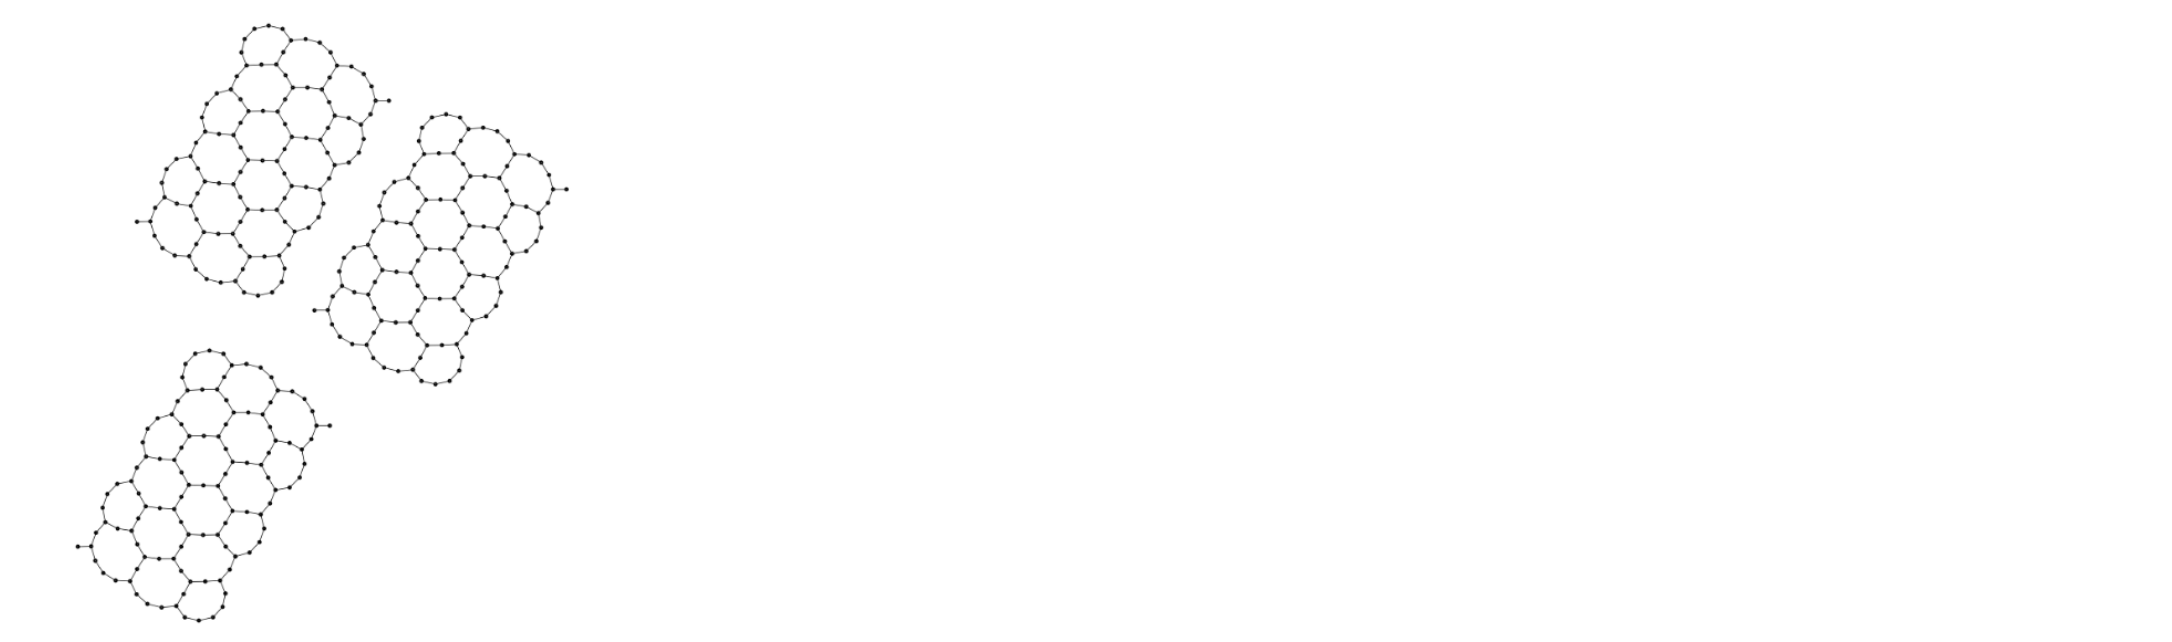

In [ ]:
# Submit your answer using following code

grade_lab5_ex3(t_ghz_qc)   # Expected result type: QuantumCircuit (Instruction Set Architecture )

In this example, we needed to create a circuit that can be easily divided by the transpiler into 3 sections.

What happens if we didn't do that? what happens if we built the circuit as a one big set of gates? Like the Bernstein Vazirani algorithm?


### 2.2 The Large Bernstein-Vazirani Algorithm

The Bernstein-Vazirani algorithm is a quantum algorithm designed to identify a hidden string with fewer queries compared to classical methods.

Imagine there is a hidden binary string s (for example, "1101"), and you have access to a function $ f(x)$ that returns the inner product (dot product) of $x$ and $s$. The goal is to determine the hidden string $s$:

$
f(x) = x \cdot s\mod 2.
$

Classically, to find the hidden string s of length $n$, you would need to query the function $f(x) n$ times with different inputs to determine each bit of $s$.



1. **Superposition**: Apply a Hadamard gate to each of the $ n $ qubits to create a superposition of all possible input states.
2. **Oracle Query**: Use an oracle that implements the function $f$. This step entangles the input qubits with the result of $f(x)$.
3. **Interference**: Apply another round of Hadamard gates to the $n$ qubits to create interference patterns that reveal the hidden string $s$.
4. **Measurement**: Measure the $n$ qubits. The result of this measurement directly gives you the hidden string $s$ in a single query to the oracle.

In essence, the Bernstein-Vazirani algorithm leverages quantum superposition and interference to solve the problem with just one query to the function $ f $, which is exponentially faster than the classical method that requires $ n $ queries.

<a id="exercise4"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 4:</b> 

Write a code implementing Bernstein-Vazirani algorithm for a 345 qubits. The hidden binary string $s = 1111.....11$ (344 1's here!).


</div>

Let's implement the algorithmic steps above for a circuit containing 345 qubits (n= 345). A simple oracle for this problem would be a controlled-NOT (CNOT) gate applied the first $n-1$ as control and the last qubit as target. This will ensure that the last qubit's state will flip only if qubits 0~344 are 1.

In [ ]:
#Implement the Bernstein-Vazirani circuit and the perform a measureall operatoion
num_qubits = 345
bv = QuantumCircuit(num_qubits, num_qubits - 1)
## your code goes here ##



In [ ]:
# Submit your answer using following code

grade_lab5_ex4(bv)    # Expected result type: QuantumCircuit

If we try to transpile this circuit on our 3 chip system, we get an error.

In [ ]:
from qiskit.transpiler import TranspilerError
try:
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=40000)
    t_bv_qc = pm.run(bv)
except TranspilerError as e:
    print(e)

Here we got an error because the transplier can't divide the circuit by itself and the entire circuit was 345 qubits which is larger than the size of a single chip.

We can avoid that by using a different circuit topology, namely, the grid topology!

### 2.3 A Grid backend inspired by a Toric code

In order to map 345 qubits circuit which the transplier can't divide, now we use a different topology **grid graph** that has 19 rows and 19 columns (that is 361 qubits).  For this backend, we will use the `directed_grid_graph`. This will generate a 361 grid qubits backend that we can use to execute the Bernstein-Vazirani circuit without the need to divide it!

The `directed_grid_graph` is inspired by the topology of **Toric codes**. 

    The toric code is a two-dimensional topological quantum error-correcting code proposed by Alexei Kitaev in 1997. It is defined on a toroidal lattice, which wraps around itself in both horizontal and vertical directions, resembling the surface of a doughnut. The toric code encodes logical qubits using non-local, topological properties of the lattice.

    Each qubit in the toric code is associated with a vertex or a plaquette of the lattice. The logical qubits are encoded using non-trivial topological configurations of qubits on the lattice.

    Errors in the toric code, such as single-qubit and multi-qubit errors, are corrected using non-local measurements of certain observables associated with plaquettes and vertices of the lattice. These measurements allow the detection and correction of errors without directly measuring the state of individual quber run method.

<a id="exercise5"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 5:</b> 

Build a fully connected directed grid fake backend of 361 qubits (19 rows and 19 columns) and transpile the Bernstein-Vazirani circuit on it.    


**Note:**
- Use the same basis gates and their proparties as defined in **Exercise 3**.
- You need to use `generate_preset_pass_manager` function, and set the `seed_transpiler parameter` to 40000, the `optimization_level parameter` to 2.
</div>

In [ ]:
class FakeTorusBackend(BackendV2):

    def __init__(self):
        """Instantiate a new backend that is inspired by a toric code"""
        super().__init__(name='Fake LOCC backend')
        ## your code goes here ##
        n =   #ADD the value of n
        
        graph = rx.generators.directed_grid_graph(n, n)
        for column in range(n):
            graph.add_edge(column, (n-1)*n + column, None)
        for row in range(n):
            graph.add_edge(row * n, row * n + (n-1), None)
        num_qubits = len(graph)
        rng = np.random.default_rng(seed=12345678942)
        
        # Define your gates props here
        ## your code goes here ##

        
        measure_props = {}
        delay_props = {}
        self._target = Target("Fake Kookaburra", num_qubits=num_qubits)
        # Add 1q gates. Globally use virtual rz, x, sx, and measure
        for i in range(num_qubits):
            qarg = (i,)

            # Add your gates here
            ## your code goes here ##

            
            
            measure_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-3, 1e-1), duration=rng.uniform(1e-8, 9e-7)
            )
            delay_props[qarg] = None

        #Append your gates to the backend here using self._target.add_instruction
        ## your code goes here ##
        
        
        self._target.add_instruction(Measure(), measure_props)
        self._target.add_instruction(Reset(), measure_props)
        self._target.add_instruction(Delay(Parameter("t")), delay_props)
        cz_props = {}
        for edge in graph.edge_list():
            offset = i * len(graph)
            cz_props[edge] = InstructionProperties(
                error=rng.uniform(7e-4, 5e-3), duration=rng.uniform(1e-8, 9e-7)
            )
        self._target.add_instruction(CZGate(), cz_props)

    @property
    def target(self):
        return self._target

    @property
    def max_circuits(self):
        return None

    @classmethod
    def _default_options(cls):
        return Options(shots=1024)

    def run(self, circuit, **kwargs):
        raise NotImplementedError("Can't implement")

In [ ]:
# Create the backend
backend_connected = ## your code goes here ##

We can now create the backend and draw it

In [ ]:
plot_gate_map(backend_connected)

In [ ]:
# Compile the bv circuit
## your code goes here ##

t_bv_qc = ## your code goes here ##

Now we can plot the backend and see which qubits are used.

In [ ]:
# If you cannot execute this cell, no effect to your grade.
# You can see the layout on the backend, if Graphviz is installed.

plot_circuit_layout(t_bv_qc, backend_connected)

If Graphviz is working in your environment, you can see below figure.

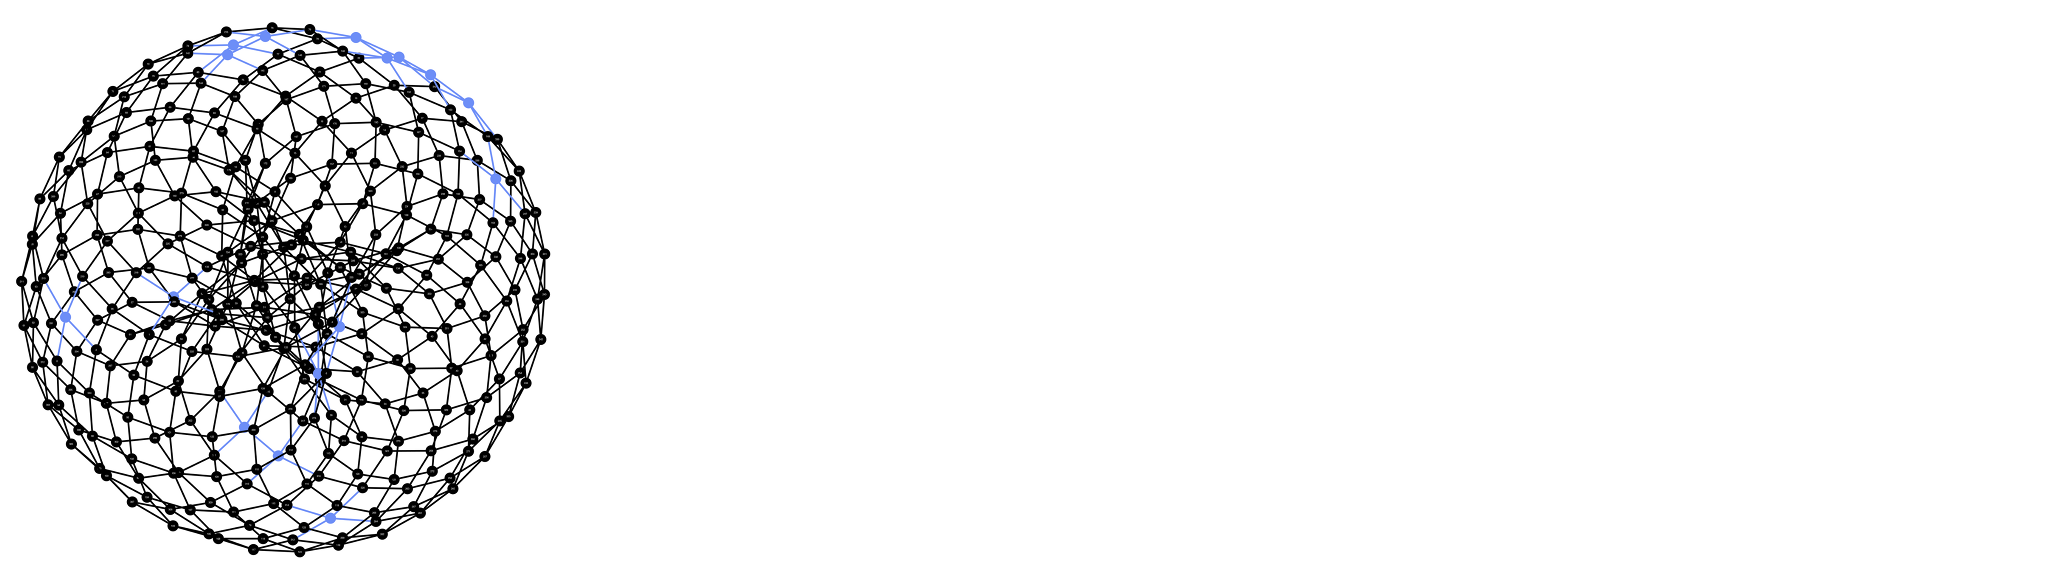

In [ ]:
# Submit your answer using following code

grade_lab5_ex5(t_bv_qc)   # Expected result type: QuantumCircuit (Instruction Set Architecture )

This gives you an idea on what you can do with the fake backend feature in Qiskit 1.0. So go ahead and imagine the future of quantum computing hardware!


# 3. Code Assistant

# Additional information

**Created by:** Kifumi Numata, Sara Metwalli, Siddharth Golecha

**Advised by:** Junye Huang

**Version:** 1.0

# Qiskit packages versions

In [1]:
import qiskit
import qiskit_ibm_runtime
import circuit_knitting

print(f'Qiskit: {qiskit.__version__}')
print(f'Qiskit IBM Runtime: {qiskit_ibm_runtime.__version__}')
#print(f'Circuit Knitting Toolbox: {circuit_knitting.__version__}')

/Users/kifumi/local/qiskit_env/qiskit_102_0503/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Qiskit: 1.0.2
Qiskit IBM Runtime: 0.23.0


> Print main qiskit packages versions. Print only packages that are used in the notebook. Rememeber to add additional packages that are used in the notebook like `prototype-zne` or `circuit-knitting-toolbox`.